# Import/load data

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np


# Load data
cases = pd.read_csv("cases.tsv", sep="\t")
population = pd.read_csv("population.tsv", sep="\t")

# Merge the cases and population data on 'agegroup', 'sex', and 'year' columns
full_data = pd.merge(population, cases, on = ["agegroup", "sex", "year"])
full_data

,agegroup,sex,year,n_pop,n
0,0-4,Male,1970,296143,0
1,5-9,Male,1970,295092,0
2,10-14,Male,1970,272559,0
3,15-19,Male,1970,281997,1
4,20-24,Male,1970,336648,3
...,...,...,...,...,...
1903,65-69,Female,2022,273778,256
1904,70-74,Female,2022,269193,394
1905,75-79,Female,2022,259291,569
1906,80-84,Female,2022,167556,497


# Question 7

We will apply the statsmodels library to fit a GLM with a poisson faimly and a log link function.

In [3]:
# Summarize the total number of cases and total population by 'year' and 'sex'
total_cases_population_df = full_data.groupby(['year', 'sex']).agg(
    total_cases=('n', 'sum'),
    total_population=('n_pop', 'sum')
).reset_index()


# Ensure that 'sex' is treated as a categorical variable for modeling purposes
total_cases_population_df['sex'] = total_cases_population_df['sex'].astype('category')

# Calculate the natural logarithm of the total population to use as an offset in the Poisson model
# The offset adjusts for different population sizes across groups
total_cases_population_df['log_total_population'] = np.log(total_cases_population_df['total_population'])

# Fit a Poisson regression model using Generalized Linear Models (GLM)
# The model predicts 'total_cases' based on 'year' and 'sex', adjusting for population size
poisson_model = smf.glm(
    formula='total_cases ~ year + C(sex)',
    data=total_cases_population_df,
    family=sm.families.Poisson(),
    offset=np.log(total_cases_population_df['total_population'])
).fit()

# Print the summary of the fitted Poisson regression model
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  106
Model:                            GLM   Df Residuals:                      103
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -602.69
Date:                Tue, 19 Nov 2024   Deviance:                       222.81
Time:                        10:08:17   Pearson chi2:                     223.
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -29.6942      0.307    -96.

Interpretation:

Intercept; The estimated baseline log incidence rate when year = 0 and sex is the reference category, e.g., "Female".

C(sex)[T.Male]; Being male is associated with an decrease in the log incidence rate of -0.0559 compared to females

year; For each additional year, the log incidence rate increases by approximately 0.0109. This means that we have an increasing trend in incidence over time.

# Model fit check

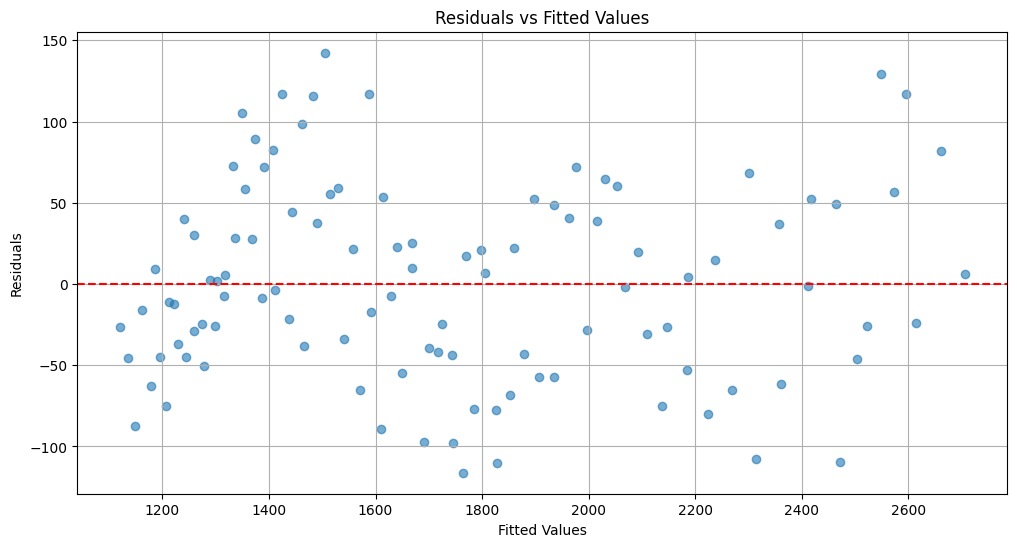

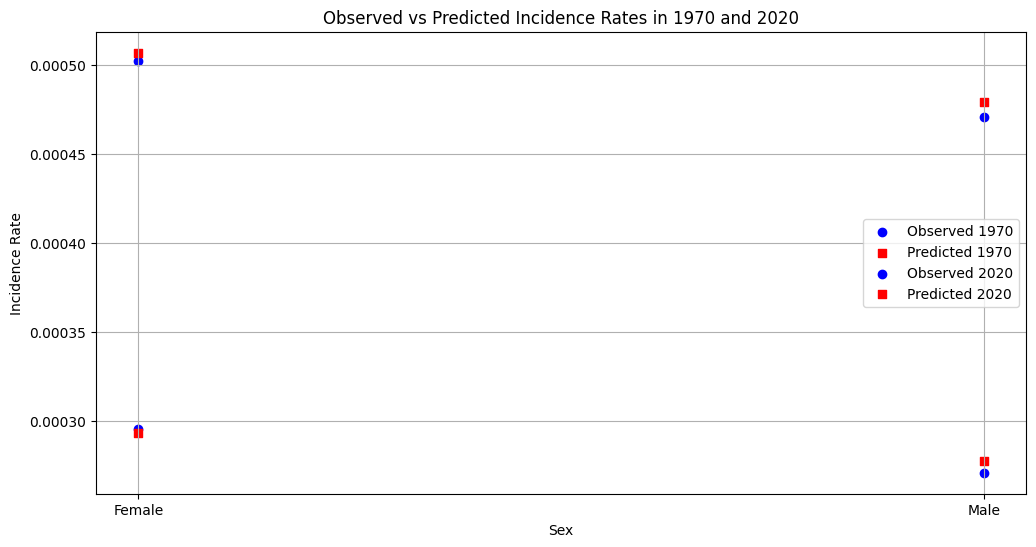

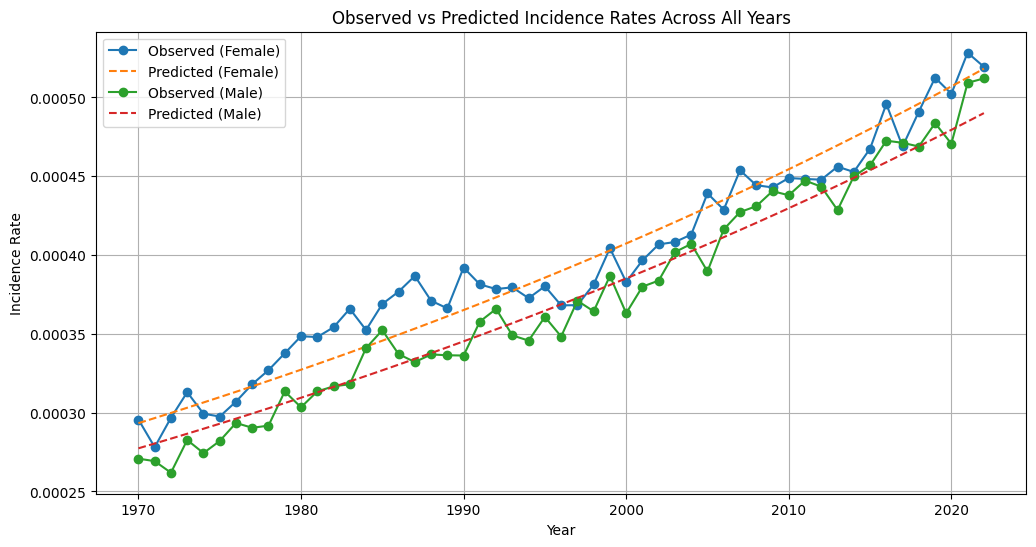

In [8]:
# Summarize total cases and population by year and sex
total_cases_population_df = full_data.groupby(['year', 'sex']).agg(
    total_cases=('n', 'sum'),
    total_population=('n_pop', 'sum')
).reset_index()

# Calculate observed incidence rate
total_cases_population_df['observed_incidence_rate'] = (
    total_cases_population_df['total_cases'] / total_cases_population_df['total_population']
)

# Get predicted values from the model
predicted_values = poisson_model.fittedvalues
total_cases_population_df['predicted_cases'] = predicted_values

# Calculate predicted incidence rate
total_cases_population_df['predicted_incidence_rate'] = (
    total_cases_population_df['predicted_cases'] / total_cases_population_df['total_population']
)

# Residual Analysis
residuals = total_cases_population_df['total_cases'] - total_cases_population_df['predicted_cases']
plt.figure(figsize=(12, 6))
plt.scatter(predicted_values, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.grid(True)
plt.show()

# Filter for the years 1970 and 2020
years_of_interest = [1970, 2020]
data_filtered = total_cases_population_df[total_cases_population_df['year'].isin(years_of_interest)]

# Plot observed vs predicted incidence rates for 1970 and 2020 without connecting lines
plt.figure(figsize=(12, 6))
for year in years_of_interest:
    subset = data_filtered[data_filtered['year'] == year]
    plt.scatter(subset['sex'], subset['observed_incidence_rate'], label=f'Observed {year}', color='blue', marker='o')
    plt.scatter(subset['sex'], subset['predicted_incidence_rate'], label=f'Predicted {year}', color='red', marker='s')

plt.xlabel('Sex')
plt.ylabel('Incidence Rate')
plt.title('Observed vs Predicted Incidence Rates in 1970 and 2020')
plt.legend()
plt.grid(True)
plt.show()

# Plot observed vs predicted incidence rates across all years
plt.figure(figsize=(12, 6))
for sex in total_cases_population_df['sex'].unique():
    subset = total_cases_population_df[total_cases_population_df['sex'] == sex]
    plt.plot(subset['year'], subset['observed_incidence_rate'], label=f'Observed ({sex})', marker='o')
    plt.plot(subset['year'], subset['predicted_incidence_rate'], label=f'Predicted ({sex})', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Incidence Rate')
plt.title('Observed vs Predicted Incidence Rates Across All Years')
plt.legend()
plt.grid(True)
plt.show()



# Question 8

In [20]:
# Extract model parameters
params = poisson_model.params

intercept = params['Intercept']
beta_year = params['year']
# 'C(sex)[T.Male]' represents the effect of being male compared to the reference category (female)
beta_sex_male = params['C(sex)[T.Male]']  # Difference between males and females

# Compute predicted incidence rates
# The incidence rate per 100,000 is calculated by exponentiating the linear predictor and scaling by 100,000
incidence_rate_female_1970 = np.exp(intercept + beta_year * 1970) * 100000
incidence_rate_female_2020 = np.exp(intercept + beta_year * 2020) * 100000

# For males
# Add the 'beta_sex_male' coefficient to account for the difference between males and females
incidence_rate_male_1970 = np.exp(intercept + beta_year * 1970 + beta_sex_male) * 100000
incidence_rate_male_2020 = np.exp(intercept + beta_year * 2020 + beta_sex_male) * 100000

# Prints
print(f"Predicted incidence rate for females in 1970(per 100,000): {incidence_rate_female_1970}")
print(f"Predicted incidence rate for males in 1970(per 100,000): {incidence_rate_male_1970}")
print(f"Predicted incidence rate for females in 2020(per 100,000): {incidence_rate_female_2020}")
print(f"Predicted incidence rate for males in 2020(per 100,000): {incidence_rate_male_2020}")


Predicted incidence rate for females in 1970(per 100,000): 29.332714895478954
Predicted incidence rate for males in 1970(per 100,000): 27.73750529412747
Predicted incidence rate for females in 2020(per 100,000): 50.6991828283409
Predicted incidence rate for males in 2020(per 100,000): 47.94199436090355
